<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/78_Ultra_Lite_Pytorch_%D0%A7%D0%B0%D1%81%D1%82%D1%8C_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra Lite

Макс 10 баллов

Возьмите шаблон ноутбука и напишите по памяти сеть, построенную на предобученной сети для классификации изображений, используя альтернативный датасет из библиотеки torchvision.

In [ ]:
from torchvision import models # здесь лежат предобученные сетки

#import argparse
from types import SimpleNamespace # простой класс, где можно прописать параметры
import json

# Для визуализации
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import time
import scipy
from google.colab import files

# Библиотеки Pytorch
import torch 
import torchvision # здесь лежит mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets #работа с классом Датасет

# Вывод информации о модели
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Проверяем доступен ли GPU и выбираем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Пример использования предобученной модели




In [ ]:
# загружаем готовую vgg16 с предобученными весами, переключаем в режим проверки (evaluate)
vgg16 = torchvision.models.vgg16(pretrained=True).eval().to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(vgg16, (3,64,64)) # посмотрим архитектуру VGG16 и размерности в слоях

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [ ]:
vgg16.avgpool # выводим слой, отвечающий за классификацию

AdaptiveAvgPool2d(output_size=(7, 7))

## Настройка (Fine-tuning) предобученной модели



Загрузим CIFAR100

In [ ]:
batchSize = 100 # Зададим размер батча
numClasses = 100 # Зададим количество классов
numEpochs = 10 # Зададим количество эпох для обучения
learningRate = 0.00001 # Зададим параметр learningRate для оптимайзера

trainDataset = dsets.CIFAR100(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True) # Загружаем обучающую выборку CIFAR100

testDataset = dsets.CIFAR100(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor()) # Загружаем тестовую выборку CIFAR100

trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, 
                                           batch_size=batchSize, 
                                           shuffle=True) # Создаем загрузчик для обучающей выборки

testLoader = torch.utils.data.DataLoader(dataset=testDataset, 
                                          batch_size=batchSize, 
                                          shuffle=False) # Создаем загрузчик для тестовой выборки

Files already downloaded and verified


In [ ]:
summary(vgg16, (3,32,32)) # посмотрим архитектуру VGG16 и размерности в слоях

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
iterator = iter(trainLoader)  # Создаем итератор для обучающей выборки
samples, labels = next(iterator) # Получим первую партию изображений и меток

In [ ]:
samples = samples.to(device) # отправляем картинки на выбранное устройство
labels = labels.to(device) # отправляем метки классов на выбранное устройство

In [ ]:
samples.shape # это наша конечная форма

torch.Size([100, 3, 32, 32])

In [ ]:
# Узнаем, с каким размером мы работаем, чтоб ввести правильные параметры слоя
print(vgg16.avgpool(vgg16.features(samples)).shape) # мы пропустили через features, передали на avgpool и посмотрели во что он слепил выборку

torch.Size([100, 512, 7, 7])


In [ ]:
for param in vgg16.parameters(): # поскольку мы будем тренировать под наш сет только последний слой
    param.requires_grad = False # не будем обновлять веса всей сети. Заморозим их

# Заменим последний слой для настройки под наш датасет
vgg16.classifier = nn.Linear(25088, 100).to(device) # 25088 = 7*7*512 - в качестве входных нейронов подаем результат вытягивания того, что на AveragePooling2D(avgpool)
                                                   # на выходе 100 нейронов, т.к. 10 классов

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(vgg16, (3,32,32)) # посмотрим архитектуру VGG16 и размерности в слоях

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
# Функция ошибки
criterion = nn.CrossEntropyLoss() 
# Оптимизатор. Поскольку тренируем только слой классификатор, то его параметры и подаем на вход
optimizer = torch.optim.Adam(vgg16.classifier.parameters(), lr=learningRate)

# Обучим наш последний слой
for epoch in range(numEpochs):
    for i, (images, labels) in enumerate(trainLoader): 
        images = images.to(device)
        labels = labels.to(device)       
        optimizer.zero_grad() # обнуляем градиенты
        outputs = vgg16(images) # подаем изображения на вход
        loss = criterion(outputs, labels) # считаем ошибку
        loss.backward() # берем производную
        optimizer.step() # делаем шаг оптимизатором
        
        if (i+1) % 10 == 0:
            print('Эпоха: [%d/%d], Шаг: [%d/%d], Потеря: %.4f' 
                  % (epoch+1, numEpochs, i+1, len(trainDataset)//batchSize, loss))

Эпоха: [1/10], Шаг: [10/500], Потеря: 4.5954
Эпоха: [1/10], Шаг: [20/500], Потеря: 4.4023
Эпоха: [1/10], Шаг: [30/500], Потеря: 4.2727
Эпоха: [1/10], Шаг: [40/500], Потеря: 4.2515
Эпоха: [1/10], Шаг: [50/500], Потеря: 4.1217
Эпоха: [1/10], Шаг: [60/500], Потеря: 3.8864
Эпоха: [1/10], Шаг: [70/500], Потеря: 3.8210
Эпоха: [1/10], Шаг: [80/500], Потеря: 3.8818
Эпоха: [1/10], Шаг: [90/500], Потеря: 3.8070
Эпоха: [1/10], Шаг: [100/500], Потеря: 3.6507
Эпоха: [1/10], Шаг: [110/500], Потеря: 3.7403
Эпоха: [1/10], Шаг: [120/500], Потеря: 3.5520
Эпоха: [1/10], Шаг: [130/500], Потеря: 3.5880
Эпоха: [1/10], Шаг: [140/500], Потеря: 3.3931
Эпоха: [1/10], Шаг: [150/500], Потеря: 3.7291
Эпоха: [1/10], Шаг: [160/500], Потеря: 3.4440
Эпоха: [1/10], Шаг: [170/500], Потеря: 3.4328
Эпоха: [1/10], Шаг: [180/500], Потеря: 3.3799
Эпоха: [1/10], Шаг: [190/500], Потеря: 3.2257
Эпоха: [1/10], Шаг: [200/500], Потеря: 3.3114
Эпоха: [1/10], Шаг: [210/500], Потеря: 3.3187
Эпоха: [1/10], Шаг: [220/500], Потеря: 3.17

In [ ]:
torch.save(vgg16, '/content/drive/MyDrive/Предобученные сети/vgg16_pytorch.pkl')
#vgg16 = torch.load('/content/drive/MyDrive/Предобученные сети/vgg16_pytorch.pkl')

In [ ]:
curTime = time.time()
vgg16.eval()  # включаем режим проверки
correct = 0
total = 0

for images, labels in testLoader: # проходимся по всему тестовому загрузчику
    images = images.to(device)
    labels = labels.to(device) 
    outputs = vgg16(images) # классифицируем
    _, predicted = torch.max(outputs.data, 1) # вытаскиваем индексы лейблов
    total += labels.size(0) # здесь лежит количество всего
    correct += (predicted == labels).sum() # считаем количество совпадений
    
print('Точность для 10000 картинок: %d %%' % (100 * correct // total))
print('time: ', round(time.time()-curTime,2),' с',sep='')

Точность для 10000 картинок: 37 %
time: 1.61 с


In [ ]:
predicted.shape # размер предикта 

torch.Size([100])

In [ ]:
images[0].shape # размер одной картинки

torch.Size([3, 32, 32])

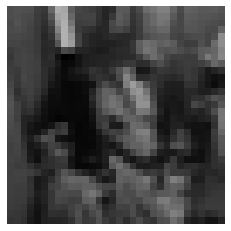

Предсказание: tensor(51, device='cuda:0')


In [ ]:
n = 6
im = images[n,1].cpu().numpy() # Превращаем шестую картинку в numpy
im = 255*np.reshape(im,(32,32)) # Приводим к формату RGB
x = Image.fromarray(im.astype(np.uint8)).convert('RGBA') #Данные массива должны быть универсальной кодировки и приводим к формату изображения

plt.imshow(x)
plt.axis('off')
plt.show()

# Предсказание

print("Предсказание:", labels[predicted[n].item()])


Не нашла как получить название 51-го класса. В PyTorch документации не увидела. Подскажите, пожалуйста?????